# Replace star sampling with sampling ranges of L M and T

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import numpy as np
from numpy import random, pi, array
import swarms
import pread as pds
from random import randint, seed, uniform
#plt.style.use('paper')
from swarms import MMOON, MJUP, RJUP, AU, REARTH, MEARTH, PC, MSUN, LSUN, YEAR, MICRON

In [2]:
GPI = pd.read_csv("./data/fullGPIsample.csv", index_col=0)
GPI = GPI[~GPI['Distance_distance'].isnull()]
GPI = GPI.reset_index(drop=True)
GPI['Age'] = 0

In [3]:
GPI.tail()

,S_Type,Distance_distance,FLUX_I,FLUX_H,Fe_H_Teff,Class,subtype,Mbol,Lum,Teff,Mass,Age
594,B9V,48.5835,NaN,4.622,10860,B,9,0.570,46.558609,10850.0,2.455,0
595,A7III/IV,67.1100,NaN,5.879,7834,A,7,2.445,8.279422,8000.0,1.595,0
596,F6V,35.3895,6.370,5.787,6255,F,6,3.860,2.249055,6400.0,1.160,0
597,K2V,21.9270,7.194,6.007,0,K,2,5.620,0.444631,4930.0,0.738,0
598,A1V,47.0754,NaN,4.949,9057,A,1,1.440,20.892961,9370.0,2.005,0


In [4]:
def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def star_sampler(mean=2., std=1.):
    '''
    Mstar = None
    Lstar = None
    Tstar = None
    dpl = None
    
    sample = int(random.normal(loc=mean, scale=std))
    sampled_type = 'M' + str(sample)
    for i in range(len(GPI['S_Type'])):
        if sampled_type in GPI['S_Type'][i]:
            Tstar = GPI['Teff'][i]
            Lstar = GPI['Lum'][i]*Lsun
            Mstar = GPI['Mass'][i]*Msun
            dpl = GPI['Distance_distance'][i]*pc
            break
    '''
    # Table 1 (KALTENEGGER & TRAUB) https://arxiv.org/ftp/arxiv/papers/0903/0903.3371.pdf
    ML = [7.2/100., 3.5/100., 2.3/100., 1.5/100., 0.55/100., 0.22/100., 0.09/100., 0.05/100., 0.03/100., 0.015/100.]
    MM = [0.60, 0.49, 0.44, 0.36, 0.20, 0.14, 0.10, 0.09, 0.08, 0.075]
    MT = [3800, 3600, 3400, 3250, 3100, 2800, 2600, 2500, 2400, 2300]
    sample = -1
    while sample < 0 or sample > 9:
        sample = int(random.normal(loc=mean, scale=std))
    
    return swarms.Star(M=MM[sample]*MSUN, L=ML[sample]*LSUN, T=MT[sample], d=0) # M star

def distance_sampler(mean, std):
    s = 0
    while s <= 0:
        s = random.normal(loc=mean, scale=std)
    return s

def draw_planet(star, age, IWA=0.2, OWA=1.2):
    Mmin = 20 # Mearth (just over Nep. Lowest val in Baraffe)
    Mmax = 5*318 # Mearth (5 MJup. Highest in Baraffe)
    # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
    totoccurrence = 1.
    Npts = 1000
    alpha = -0.86
    Q = 0.5 # planet albedo
    ms = np.linspace(Mmin, Mmax, Npts)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
    randv = np.random.uniform()
    idx = np.searchsorted(cumpdf, randv)
    if idx == len(cumpdf):
        return None # didn't draw a planet
    else:
        # draw semimajor axis
        amin = star.d/PC*IWA# AU
        amax = star.d/PC*OWA # AU
        a = loguniform(amin, amax)
        return swarms.Planet(star, M=ms[idx]*MEARTH , R=None, a=a*AU, Q=Q, Z='002', age=age)
    
def contrast_scat(A, g, Q, a_pl):
    return (A*g*Q) / (np.pi*a_pl**2)

def cdf(x):
    """create a lin-log cdf function using the points,
        (20, 0.0)
        (135, 0.5)
        (620, 0.9)
    from Bowler & al. 2014."""
    A = -0.785
    B = 0.603
    if isinstance(x, float) or isinstance(x, int):
        return A + B*np.log10(x)
    else:
        f = np.zeros(len(x))
        for i in range(len(x)):
            if x[i] < 20:
                f[i] = 0
            else:
                f[i] = A + B*np.log10(x[i])
                if f[i] > 1.0:
                    f[i] = 1.0
        return f
    
def inverse_cdf(y):
    A = -0.785
    B = 0.603
    return 10**((y - A)/B)  
    
def age_sampler2():
    y = uniform(0, 1)
    return inverse_cdf(y)*1e6 * YEAR

def age_sampler():
    return loguniform(1.1e7, 1e8) * YEAR

def Fscat(F_star, R_plt, g, Q, d_pl):
    return F_star * R_plt**2 * g * Q / (d_pl**2)

def Fstar(Ls, Bnu, Ts, dpl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * dpl ** 2
    return part1 / part2

def lum_to_temp(L, R):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = L / (4 * pi * sig * R**2)
    return (part1)**(1./4.)

# Sample

In [5]:
IWA = 0.2 # arcseconds
OWA = 1.2
MWA = (IWA + OWA)/2
lamb = 1.65 * MICRON

M0 = 1*MEARTH
aopt = 200 # AU
dopt = aopt/MWA * PC
print('Optimal Distance = {0:.0f} pc'.format(dopt/PC))

Optimal Distance = 286 pc


In [9]:
def sample(M0, dopt, lamb, star_type):
    if star_type == "G2":
        star = swarms.Star(1.*LSUN, 1.*MSUN, 5780, d=0)
    elif star_type == "M0":
        star = swarms.Star(0.072*LSUN, 0.60*MSUN, 3800, d=0)
    elif star_type == "K5":
        star = swarms.Star(0.16*LSUN, 0.69*MSUN, 4410, d=0)
    elif star_type == "G5":
        star = swarms.Star(0.79*LSUN, 0.93*MSUN, 5610, d=0)
    elif star_type == "F5":
        star = swarms.Star(2.5*LSUN, 1.3*MSUN, 6540, d=0)
    elif star_type == "F0":
        star = swarms.Star(5.2*LSUN, 1.4*MSUN, 7420, d=0)
    else:
        print("randomizing")
        star = star_sampler()
    star.d = dopt#distance_sampler(mean=dopt, std=dopt/2.)
    if star.Imag < 0 or star.Imag > 12:
        #print(star.Imag)
        return sample(M0, dopt, lamb, star_type) # do it again
    age = 11e6 * YEAR # age_sampler()
    
    planet = draw_planet(star, age=age)
    if planet is None:
        return sample(M0, dopt, lamb, star_type) # do it again
    
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = uniform(0.2, 0.4) # eta
    Q = loguniform(0.05, 0.25) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    swarm = swarms.CollSwarm(star, planet, M0=M0, Dt=Dt, Dmax=Dmax, Q=Q, g=g, eta=eta, Nstr=Nstr, 
                            rho=rho, fQ=fQ, Dmin_min=lamb, age=age)
    CRscatSwarm = swarm.computeCRscat()
    CRscatPlanet = planet.computeCRscat(g)
    CRthermalPlanet = planet.computeCRthermal(lamb)
    print("Mtot: {0:.2e} \t Tcol: {1:.2e} \t tnleft: {2:.2e} \t Tcol0: {3:.2e} \t 1/(Mplt^0.24 * apl^4.13): {4:.2e}".format(swarm.swarm.M0/MEARTH, swarm.computeTcol()/YEAR, swarm.tnleft/YEAR, swarm.Tcol0, 1./((swarm.planet.M/MEARTH)**0.24 * (swarm.planet.a/AU)**4.13)))
    if np.isnan(CRthermalPlanet):
        CRthermalPlanet = 0
    return CRscatSwarm, CRscatPlanet+CRthermalPlanet, planet.a/AU, star.d/PC, planet.M, star.Imag

In [10]:
%%time
seed(0)
M1 = 1*MEARTH
dopt1 = 60 * PC
star_type1 = "M0"
Nsamples = 300
CRscatSwarm1, CRPlanet1, a1, d1, Mplt1, Imag1 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm1[i], CRPlanet1[i], a1[i], d1[i], Mplt1[i], Imag1[i] = sample(M1, dopt1, lamb, star_type1)

Mtot: 3.93e-01 	 Tcol: 1.81e+07 	 tnleft: 5.41e+11 	 Tcol0: 2.25e+14 	 1/(Mplt^0.24 * apl^4.13): 1.46e-08
Mtot: 8.34e-04 	 Tcol: 1.10e+07 	 tnleft: 3.40e+10 	 Tcol0: 2.90e+11 	 1/(Mplt^0.24 * apl^4.13): 1.77e-06
Mtot: 7.09e-03 	 Tcol: 1.11e+07 	 tnleft: 6.60e+12 	 Tcol0: 2.48e+12 	 1/(Mplt^0.24 * apl^4.13): 1.33e-07
Mtot: 5.27e-01 	 Tcol: 2.33e+07 	 tnleft: 1.33e+11 	 Tcol0: 3.87e+14 	 1/(Mplt^0.24 * apl^4.13): 7.00e-08
Mtot: 8.98e-01 	 Tcol: 1.08e+08 	 tnleft: 4.13e+11 	 Tcol0: 3.06e+15 	 1/(Mplt^0.24 * apl^4.13): 9.98e-09
Mtot: 6.76e-04 	 Tcol: 1.10e+07 	 tnleft: 9.58e+08 	 Tcol0: 2.35e+11 	 1/(Mplt^0.24 * apl^4.13): 1.44e-05
Mtot: 1.12e-02 	 Tcol: 1.11e+07 	 tnleft: 1.14e+13 	 Tcol0: 3.92e+12 	 1/(Mplt^0.24 * apl^4.13): 1.96e-08
Mtot: 4.81e-01 	 Tcol: 2.12e+07 	 tnleft: 4.15e+11 	 Tcol0: 3.22e+14 	 1/(Mplt^0.24 * apl^4.13): 1.28e-08
Mtot: 3.76e-04 	 Tcol: 1.10e+07 	 tnleft: 5.46e+09 	 Tcol0: 1.31e+11 	 1/(Mplt^0.24 * apl^4.13): 7.33e-06
Mtot: 2.86e-02 	 Tcol: 1.13e+07 	 tnleft: 2.59

Mtot: 1.18e-04 	 Tcol: 1.10e+07 	 tnleft: 1.04e+10 	 Tcol0: 4.08e+10 	 1/(Mplt^0.24 * apl^4.13): 8.61e-06
Mtot: 1.42e-04 	 Tcol: 1.10e+07 	 tnleft: 8.98e+09 	 Tcol0: 4.93e+10 	 1/(Mplt^0.24 * apl^4.13): 7.20e-06
Mtot: 1.99e-03 	 Tcol: 1.10e+07 	 tnleft: 6.99e+11 	 Tcol0: 6.91e+11 	 1/(Mplt^0.24 * apl^4.13): 6.24e-08
Mtot: 1.84e-03 	 Tcol: 1.10e+07 	 tnleft: 2.43e+10 	 Tcol0: 6.39e+11 	 1/(Mplt^0.24 * apl^4.13): 2.02e-06
Mtot: 4.54e-04 	 Tcol: 1.10e+07 	 tnleft: 4.35e+11 	 Tcol0: 1.58e+11 	 1/(Mplt^0.24 * apl^4.13): 4.13e-07
Mtot: 1.05e-04 	 Tcol: 1.10e+07 	 tnleft: 1.85e+11 	 Tcol0: 3.63e+10 	 1/(Mplt^0.24 * apl^4.13): 4.34e-07
Mtot: 1.04e-01 	 Tcol: 1.23e+07 	 tnleft: 5.75e+11 	 Tcol0: 4.02e+13 	 1/(Mplt^0.24 * apl^4.13): 4.59e-08
Mtot: 4.68e-03 	 Tcol: 1.11e+07 	 tnleft: 5.59e+12 	 Tcol0: 1.63e+12 	 1/(Mplt^0.24 * apl^4.13): 5.40e-08
Mtot: 3.82e-05 	 Tcol: 1.10e+07 	 tnleft: 3.25e+10 	 Tcol0: 1.32e+10 	 1/(Mplt^0.24 * apl^4.13): 1.12e-05
Mtot: 6.93e-02 	 Tcol: 1.18e+07 	 tnleft: 6.46

Mtot: 1.49e-01 	 Tcol: 1.29e+07 	 tnleft: 1.77e+11 	 Tcol0: 6.08e+13 	 1/(Mplt^0.24 * apl^4.13): 2.34e-07
Mtot: 5.54e-02 	 Tcol: 1.16e+07 	 tnleft: 2.28e+10 	 Tcol0: 2.04e+13 	 1/(Mplt^0.24 * apl^4.13): 2.70e-07
Mtot: 7.93e-01 	 Tcol: 5.32e+07 	 tnleft: 1.15e+11 	 Tcol0: 1.33e+15 	 1/(Mplt^0.24 * apl^4.13): 1.02e-08
Mtot: 6.11e-04 	 Tcol: 1.10e+07 	 tnleft: 1.13e+13 	 Tcol0: 2.12e+11 	 1/(Mplt^0.24 * apl^4.13): 1.48e-07
Mtot: 2.54e-04 	 Tcol: 1.10e+07 	 tnleft: 1.32e+10 	 Tcol0: 8.81e+10 	 1/(Mplt^0.24 * apl^4.13): 1.87e-06
Mtot: 7.34e-02 	 Tcol: 1.19e+07 	 tnleft: 2.78e+10 	 Tcol0: 2.75e+13 	 1/(Mplt^0.24 * apl^4.13): 2.94e-07
Mtot: 7.13e-02 	 Tcol: 1.18e+07 	 tnleft: 2.26e+10 	 Tcol0: 2.66e+13 	 1/(Mplt^0.24 * apl^4.13): 5.81e-07
Mtot: 4.22e-04 	 Tcol: 1.10e+07 	 tnleft: 4.92e+08 	 Tcol0: 1.46e+11 	 1/(Mplt^0.24 * apl^4.13): 1.31e-05
Mtot: 8.63e-05 	 Tcol: 1.10e+07 	 tnleft: 1.17e+10 	 Tcol0: 2.99e+10 	 1/(Mplt^0.24 * apl^4.13): 1.38e-06
Mtot: 4.97e-06 	 Tcol: 1.10e+07 	 tnleft: 6.95

Mtot: 4.68e-03 	 Tcol: 1.11e+07 	 tnleft: 7.26e+11 	 Tcol0: 1.63e+12 	 1/(Mplt^0.24 * apl^4.13): 3.70e-07
Mtot: 9.40e-03 	 Tcol: 1.11e+07 	 tnleft: 8.00e+09 	 Tcol0: 3.29e+12 	 1/(Mplt^0.24 * apl^4.13): 5.41e-07
Mtot: 4.34e-03 	 Tcol: 1.10e+07 	 tnleft: 8.46e+08 	 Tcol0: 1.51e+12 	 1/(Mplt^0.24 * apl^4.13): 1.38e-05
Mtot: 6.50e-03 	 Tcol: 1.11e+07 	 tnleft: 9.28e+12 	 Tcol0: 2.27e+12 	 1/(Mplt^0.24 * apl^4.13): 3.17e-08
Mtot: 1.95e-05 	 Tcol: 1.10e+07 	 tnleft: 6.78e+10 	 Tcol0: 6.78e+09 	 1/(Mplt^0.24 * apl^4.13): 8.81e-06
Mtot: 1.77e-03 	 Tcol: 1.10e+07 	 tnleft: 2.20e+09 	 Tcol0: 6.15e+11 	 1/(Mplt^0.24 * apl^4.13): 1.11e-06
Mtot: 4.02e-03 	 Tcol: 1.10e+07 	 tnleft: 2.30e+13 	 Tcol0: 1.40e+12 	 1/(Mplt^0.24 * apl^4.13): 2.28e-08
Mtot: 1.23e-02 	 Tcol: 1.11e+07 	 tnleft: 5.58e+09 	 Tcol0: 4.32e+12 	 1/(Mplt^0.24 * apl^4.13): 7.36e-07
Mtot: 5.14e-05 	 Tcol: 1.10e+07 	 tnleft: 1.61e+09 	 Tcol0: 1.78e+10 	 1/(Mplt^0.24 * apl^4.13): 3.90e-06
Mtot: 9.76e-03 	 Tcol: 1.11e+07 	 tnleft: 9.06

In [11]:
%%time
seed(0)
M2 = 0.01*MEARTH
dopt2 = 60 * PC
star_type2 = "M0"
Nsamples = 300
CRscatSwarm2, CRPlanet2, a2, d2, Mplt2, Imag2 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm2[i], CRPlanet2[i], a2[i], d2[i], Mplt2[i], Imag2[i] = sample(M2, dopt2, lamb, star_type2)

Mtot: 9.74e-03 	 Tcol: 4.26e+08 	 tnleft: 3.15e+11 	 Tcol0: 1.31e+16 	 1/(Mplt^0.24 * apl^4.13): 2.49e-08
Mtot: 7.71e-04 	 Tcol: 1.19e+07 	 tnleft: 3.40e+10 	 Tcol0: 2.90e+13 	 1/(Mplt^0.24 * apl^4.13): 1.77e-06
Mtot: 4.05e-03 	 Tcol: 1.85e+07 	 tnleft: 6.30e+12 	 Tcol0: 2.36e+14 	 1/(Mplt^0.24 * apl^4.13): 1.40e-07
Mtot: 9.91e-03 	 Tcol: 1.24e+09 	 tnleft: 1.33e+11 	 Tcol0: 3.87e+16 	 1/(Mplt^0.24 * apl^4.13): 7.00e-08
Mtot: 9.98e-03 	 Tcol: 5.10e+09 	 tnleft: 2.16e+11 	 Tcol0: 1.61e+17 	 1/(Mplt^0.24 * apl^4.13): 1.88e-08
Mtot: 8.75e-04 	 Tcol: 1.21e+07 	 tnleft: 1.36e+09 	 Tcol0: 3.33e+13 	 1/(Mplt^0.24 * apl^4.13): 1.02e-05
Mtot: 4.85e-03 	 Tcol: 2.14e+07 	 tnleft: 9.56e+12 	 Tcol0: 3.27e+14 	 1/(Mplt^0.24 * apl^4.13): 2.34e-08
Mtot: 9.94e-03 	 Tcol: 1.86e+09 	 tnleft: 7.50e+11 	 Tcol0: 5.82e+16 	 1/(Mplt^0.24 * apl^4.13): 7.13e-09
Mtot: 3.79e-04 	 Tcol: 1.14e+07 	 tnleft: 5.71e+09 	 Tcol0: 1.37e+13 	 1/(Mplt^0.24 * apl^4.13): 7.01e-06
Mtot: 7.87e-03 	 Tcol: 5.16e+07 	 tnleft: 3.24

Mtot: 2.77e-04 	 Tcol: 1.13e+07 	 tnleft: 2.73e+11 	 Tcol0: 9.89e+12 	 1/(Mplt^0.24 * apl^4.13): 6.53e-07
Mtot: 1.35e-04 	 Tcol: 1.12e+07 	 tnleft: 2.43e+11 	 Tcol0: 4.76e+12 	 1/(Mplt^0.24 * apl^4.13): 3.32e-07
Mtot: 9.28e-03 	 Tcol: 1.52e+08 	 tnleft: 6.37e+11 	 Tcol0: 4.45e+15 	 1/(Mplt^0.24 * apl^4.13): 4.15e-08
Mtot: 3.80e-03 	 Tcol: 1.78e+07 	 tnleft: 7.30e+12 	 Tcol0: 2.13e+14 	 1/(Mplt^0.24 * apl^4.13): 4.15e-08
Mtot: 4.84e-05 	 Tcol: 1.11e+07 	 tnleft: 4.13e+10 	 Tcol0: 1.69e+12 	 1/(Mplt^0.24 * apl^4.13): 8.84e-06
Mtot: 7.51e-03 	 Tcol: 4.42e+07 	 tnleft: 2.62e+10 	 Tcol0: 1.05e+15 	 1/(Mplt^0.24 * apl^4.13): 2.05e-06
Mtot: 1.82e-03 	 Tcol: 1.34e+07 	 tnleft: 4.31e+10 	 Tcol0: 7.70e+13 	 1/(Mplt^0.24 * apl^4.13): 7.77e-07
Mtot: 7.44e-03 	 Tcol: 4.29e+07 	 tnleft: 3.08e+11 	 Tcol0: 1.01e+15 	 1/(Mplt^0.24 * apl^4.13): 2.16e-07
Mtot: 9.59e-03 	 Tcol: 2.69e+08 	 tnleft: 1.29e+11 	 Tcol0: 8.15e+15 	 1/(Mplt^0.24 * apl^4.13): 3.94e-08
Mtot: 1.75e-03 	 Tcol: 1.33e+07 	 tnleft: 1.78

Mtot: 2.00e-04 	 Tcol: 1.12e+07 	 tnleft: 1.06e+10 	 Tcol0: 7.07e+12 	 1/(Mplt^0.24 * apl^4.13): 2.32e-06
Mtot: 8.99e-03 	 Tcol: 1.09e+08 	 tnleft: 3.13e+10 	 Tcol0: 3.09e+15 	 1/(Mplt^0.24 * apl^4.13): 2.63e-07
Mtot: 9.13e-03 	 Tcol: 1.26e+08 	 tnleft: 3.08e+10 	 Tcol0: 3.64e+15 	 1/(Mplt^0.24 * apl^4.13): 4.28e-07
Mtot: 6.78e-04 	 Tcol: 1.18e+07 	 tnleft: 8.47e+08 	 Tcol0: 2.52e+13 	 1/(Mplt^0.24 * apl^4.13): 7.69e-06
Mtot: 7.03e-05 	 Tcol: 1.11e+07 	 tnleft: 9.60e+09 	 Tcol0: 2.46e+12 	 1/(Mplt^0.24 * apl^4.13): 1.67e-06
Mtot: 3.35e-06 	 Tcol: 1.10e+07 	 tnleft: 4.69e+10 	 Tcol0: 1.16e+11 	 1/(Mplt^0.24 * apl^4.13): 9.26e-06
Mtot: 5.21e-03 	 Tcol: 2.30e+07 	 tnleft: 1.08e+12 	 Tcol0: 3.77e+14 	 1/(Mplt^0.24 * apl^4.13): 2.45e-08
Mtot: 3.69e-05 	 Tcol: 1.10e+07 	 tnleft: 8.58e+09 	 Tcol0: 1.29e+12 	 1/(Mplt^0.24 * apl^4.13): 6.39e-06
Mtot: 9.17e-03 	 Tcol: 1.33e+08 	 tnleft: 1.93e+10 	 Tcol0: 3.86e+15 	 1/(Mplt^0.24 * apl^4.13): 2.64e-07
Mtot: 5.52e-03 	 Tcol: 2.45e+07 	 tnleft: 9.69

Mtot: 1.09e-03 	 Tcol: 1.23e+07 	 tnleft: 1.52e+09 	 Tcol0: 4.25e+13 	 1/(Mplt^0.24 * apl^4.13): 1.60e-06
Mtot: 2.93e-03 	 Tcol: 1.56e+07 	 tnleft: 2.36e+13 	 Tcol0: 1.44e+14 	 1/(Mplt^0.24 * apl^4.13): 2.22e-08
Mtot: 5.09e-03 	 Tcol: 2.24e+07 	 tnleft: 4.64e+09 	 Tcol0: 3.60e+14 	 1/(Mplt^0.24 * apl^4.13): 8.81e-07
Mtot: 3.99e-05 	 Tcol: 1.10e+07 	 tnleft: 1.26e+09 	 Tcol0: 1.39e+12 	 1/(Mplt^0.24 * apl^4.13): 4.97e-06
Mtot: 4.16e-03 	 Tcol: 1.88e+07 	 tnleft: 6.56e+11 	 Tcol0: 2.48e+14 	 1/(Mplt^0.24 * apl^4.13): 1.82e-07
Mtot: 5.86e-03 	 Tcol: 2.66e+07 	 tnleft: 5.12e+11 	 Tcol0: 4.92e+14 	 1/(Mplt^0.24 * apl^4.13): 1.03e-07
Mtot: 9.98e-03 	 Tcol: 4.70e+09 	 tnleft: 8.65e+12 	 Tcol0: 1.48e+17 	 1/(Mplt^0.24 * apl^4.13): 9.25e-09
Mtot: 7.87e-03 	 Tcol: 5.16e+07 	 tnleft: 1.58e+09 	 Tcol0: 1.28e+15 	 1/(Mplt^0.24 * apl^4.13): 1.14e-06
Mtot: 8.92e-03 	 Tcol: 1.01e+08 	 tnleft: 5.29e+13 	 Tcol0: 2.85e+15 	 1/(Mplt^0.24 * apl^4.13): 8.20e-09
Mtot: 9.39e-03 	 Tcol: 1.80e+08 	 tnleft: 9.00

In [12]:
%%time
seed(0)
M4 = 1.e-4*MEARTH
star_type4 = "M0"
dopt4 = 60 * PC
Nsamples = 300
CRscatSwarm4, CRPlanet4, a4, d4, Mplt4, Imag4 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm4[i], CRPlanet4[i], a4[i], d4[i], Mplt4[i], Imag4[i] = sample(M4, dopt4, lamb, star_type4)

Mtot: 1.00e-04 	 Tcol: 3.18e+10 	 tnleft: 2.41e+11 	 Tcol0: 1.00e+18 	 1/(Mplt^0.24 * apl^4.13): 3.23e-08
Mtot: 9.00e-05 	 Tcol: 1.10e+08 	 tnleft: 3.67e+10 	 Tcol0: 3.13e+15 	 1/(Mplt^0.24 * apl^4.13): 1.64e-06
Mtot: 9.87e-05 	 Tcol: 8.60e+08 	 tnleft: 7.14e+12 	 Tcol0: 2.68e+16 	 1/(Mplt^0.24 * apl^4.13): 1.23e-07
Mtot: 1.00e-04 	 Tcol: 1.21e+11 	 tnleft: 1.31e+11 	 Tcol0: 3.82e+18 	 1/(Mplt^0.24 * apl^4.13): 7.09e-08
Mtot: 1.00e-04 	 Tcol: 1.07e+12 	 tnleft: 4.53e+11 	 Tcol0: 3.36e+19 	 1/(Mplt^0.24 * apl^4.13): 9.11e-09
Mtot: 8.68e-05 	 Tcol: 8.31e+07 	 tnleft: 9.28e+08 	 Tcol0: 2.27e+15 	 1/(Mplt^0.24 * apl^4.13): 1.48e-05
Mtot: 9.89e-05 	 Tcol: 9.95e+08 	 tnleft: 9.07e+12 	 Tcol0: 3.10e+16 	 1/(Mplt^0.24 * apl^4.13): 2.46e-08
Mtot: 1.00e-04 	 Tcol: 1.00e+11 	 tnleft: 4.07e+11 	 Tcol0: 3.16e+18 	 1/(Mplt^0.24 * apl^4.13): 1.30e-08
Mtot: 8.12e-05 	 Tcol: 5.85e+07 	 tnleft: 6.26e+09 	 Tcol0: 1.50e+15 	 1/(Mplt^0.24 * apl^4.13): 6.41e-06
Mtot: 9.97e-05 	 Tcol: 3.63e+09 	 tnleft: 2.89

Mtot: 5.23e-05 	 Tcol: 2.31e+07 	 tnleft: 1.94e+11 	 Tcol0: 3.81e+14 	 1/(Mplt^0.24 * apl^4.13): 4.14e-07
Mtot: 9.99e-05 	 Tcol: 1.07e+10 	 tnleft: 4.80e+11 	 Tcol0: 3.36e+17 	 1/(Mplt^0.24 * apl^4.13): 5.48e-08
Mtot: 9.78e-05 	 Tcol: 5.10e+08 	 tnleft: 5.39e+12 	 Tcol0: 1.57e+16 	 1/(Mplt^0.24 * apl^4.13): 5.59e-08
Mtot: 2.63e-05 	 Tcol: 1.49e+07 	 tnleft: 3.03e+10 	 Tcol0: 1.24e+14 	 1/(Mplt^0.24 * apl^4.13): 1.20e-05
Mtot: 9.97e-05 	 Tcol: 3.27e+09 	 tnleft: 2.57e+10 	 Tcol0: 1.03e+17 	 1/(Mplt^0.24 * apl^4.13): 2.09e-06
Mtot: 9.25e-05 	 Tcol: 1.47e+08 	 tnleft: 2.41e+10 	 Tcol0: 4.30e+15 	 1/(Mplt^0.24 * apl^4.13): 1.38e-06
Mtot: 9.94e-05 	 Tcol: 1.89e+09 	 tnleft: 1.81e+11 	 Tcol0: 5.93e+16 	 1/(Mplt^0.24 * apl^4.13): 3.63e-07
Mtot: 1.00e-04 	 Tcol: 3.14e+10 	 tnleft: 1.57e+11 	 Tcol0: 9.89e+17 	 1/(Mplt^0.24 * apl^4.13): 3.26e-08
Mtot: 9.63e-05 	 Tcol: 3.01e+08 	 tnleft: 2.20e+10 	 Tcol0: 9.13e+15 	 1/(Mplt^0.24 * apl^4.13): 6.17e-07
Mtot: 9.90e-05 	 Tcol: 1.13e+09 	 tnleft: 2.04

Mtot: 7.52e-05 	 Tcol: 4.43e+07 	 tnleft: 1.58e+10 	 Tcol0: 1.05e+15 	 1/(Mplt^0.24 * apl^4.13): 1.57e-06
Mtot: 9.99e-05 	 Tcol: 1.26e+10 	 tnleft: 4.03e+10 	 Tcol0: 3.98e+17 	 1/(Mplt^0.24 * apl^4.13): 2.05e-07
Mtot: 9.99e-05 	 Tcol: 1.35e+10 	 tnleft: 3.61e+10 	 Tcol0: 4.26e+17 	 1/(Mplt^0.24 * apl^4.13): 3.66e-07
Mtot: 8.20e-05 	 Tcol: 6.12e+07 	 tnleft: 5.32e+08 	 Tcol0: 1.58e+15 	 1/(Mplt^0.24 * apl^4.13): 1.21e-05
Mtot: 4.33e-05 	 Tcol: 1.94e+07 	 tnleft: 1.04e+10 	 Tcol0: 2.65e+14 	 1/(Mplt^0.24 * apl^4.13): 1.55e-06
Mtot: 3.89e-06 	 Tcol: 1.14e+07 	 tnleft: 5.65e+10 	 Tcol0: 1.40e+13 	 1/(Mplt^0.24 * apl^4.13): 7.70e-06
Mtot: 9.85e-05 	 Tcol: 7.19e+08 	 tnleft: 6.37e+11 	 Tcol0: 2.23e+16 	 1/(Mplt^0.24 * apl^4.13): 4.10e-08
Mtot: 2.57e-05 	 Tcol: 1.48e+07 	 tnleft: 8.02e+09 	 Tcol0: 1.20e+14 	 1/(Mplt^0.24 * apl^4.13): 6.83e-06
Mtot: 9.99e-05 	 Tcol: 1.29e+10 	 tnleft: 2.03e+10 	 Tcol0: 4.06e+17 	 1/(Mplt^0.24 * apl^4.13): 2.51e-07
Mtot: 9.94e-05 	 Tcol: 1.95e+09 	 tnleft: 1.39

Mtot: 9.86e-05 	 Tcol: 7.84e+08 	 tnleft: 5.92e+09 	 Tcol0: 2.44e+16 	 1/(Mplt^0.24 * apl^4.13): 7.26e-07
Mtot: 9.81e-05 	 Tcol: 5.70e+08 	 tnleft: 9.85e+08 	 Tcol0: 1.76e+16 	 1/(Mplt^0.24 * apl^4.13): 1.19e-05
Mtot: 9.85e-05 	 Tcol: 7.30e+08 	 tnleft: 9.28e+12 	 Tcol0: 2.27e+16 	 1/(Mplt^0.24 * apl^4.13): 3.17e-08
Mtot: 1.77e-05 	 Tcol: 1.34e+07 	 tnleft: 7.45e+10 	 Tcol0: 7.45e+13 	 1/(Mplt^0.24 * apl^4.13): 8.03e-06
Mtot: 9.30e-05 	 Tcol: 1.57e+08 	 tnleft: 1.65e+09 	 Tcol0: 4.61e+15 	 1/(Mplt^0.24 * apl^4.13): 1.48e-06
Mtot: 9.82e-05 	 Tcol: 6.24e+08 	 tnleft: 3.17e+13 	 Tcol0: 1.93e+16 	 1/(Mplt^0.24 * apl^4.13): 1.66e-08
Mtot: 9.92e-05 	 Tcol: 1.42e+09 	 tnleft: 5.75e+09 	 Tcol0: 4.46e+16 	 1/(Mplt^0.24 * apl^4.13): 7.14e-07
Mtot: 3.26e-05 	 Tcol: 1.63e+07 	 tnleft: 1.52e+09 	 Tcol0: 1.68e+14 	 1/(Mplt^0.24 * apl^4.13): 4.14e-06
Mtot: 9.89e-05 	 Tcol: 9.84e+08 	 tnleft: 8.13e+11 	 Tcol0: 3.07e+16 	 1/(Mplt^0.24 * apl^4.13): 1.47e-07
Mtot: 9.87e-05 	 Tcol: 8.67e+08 	 tnleft: 2.81

In [13]:
%%time
seed(0)
M6 = 1.e-6*MEARTH
dopt6 = 60 * PC
star_type6 = "M0"
Nsamples = 300
CRscatSwarm6, CRPlanet6, a6, d6, Mplt6, Imag6 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm6[i], CRPlanet6[i], a6[i], d6[i], Mplt6[i], Imag6[i] = sample(M6, dopt6, lamb, star_type6)

Mtot: 1.00e-06 	 Tcol: 3.34e+12 	 tnleft: 2.53e+11 	 Tcol0: 1.05e+20 	 1/(Mplt^0.24 * apl^4.13): 3.08e-08
Mtot: 9.99e-07 	 Tcol: 9.79e+09 	 tnleft: 3.62e+10 	 Tcol0: 3.08e+17 	 1/(Mplt^0.24 * apl^4.13): 1.67e-06
Mtot: 1.00e-06 	 Tcol: 6.06e+10 	 tnleft: 5.09e+12 	 Tcol0: 1.91e+18 	 1/(Mplt^0.24 * apl^4.13): 1.72e-07
Mtot: 1.00e-06 	 Tcol: 1.12e+13 	 tnleft: 1.21e+11 	 Tcol0: 3.52e+20 	 1/(Mplt^0.24 * apl^4.13): 7.68e-08
Mtot: 1.00e-06 	 Tcol: 5.09e+13 	 tnleft: 2.16e+11 	 Tcol0: 1.61e+21 	 1/(Mplt^0.24 * apl^4.13): 1.88e-08
Mtot: 9.98e-07 	 Tcol: 7.22e+09 	 tnleft: 9.28e+08 	 Tcol0: 2.27e+17 	 1/(Mplt^0.24 * apl^4.13): 1.48e-05
Mtot: 1.00e-06 	 Tcol: 8.74e+10 	 tnleft: 8.05e+12 	 Tcol0: 2.76e+18 	 1/(Mplt^0.24 * apl^4.13): 2.77e-08
Mtot: 1.00e-06 	 Tcol: 1.00e+13 	 tnleft: 4.07e+11 	 Tcol0: 3.16e+20 	 1/(Mplt^0.24 * apl^4.13): 1.30e-08
Mtot: 9.98e-07 	 Tcol: 6.17e+09 	 tnleft: 8.12e+09 	 Tcol0: 1.94e+17 	 1/(Mplt^0.24 * apl^4.13): 4.96e-06
Mtot: 1.00e-06 	 Tcol: 2.82e+11 	 tnleft: 2.25

Mtot: 9.97e-07 	 Tcol: 3.19e+09 	 tnleft: 2.77e+11 	 Tcol0: 1.00e+17 	 1/(Mplt^0.24 * apl^4.13): 6.44e-07
Mtot: 9.90e-07 	 Tcol: 1.08e+09 	 tnleft: 1.72e+11 	 Tcol0: 3.37e+16 	 1/(Mplt^0.24 * apl^4.13): 4.67e-07
Mtot: 1.00e-06 	 Tcol: 1.01e+12 	 tnleft: 4.56e+11 	 Tcol0: 3.19e+19 	 1/(Mplt^0.24 * apl^4.13): 5.76e-08
Mtot: 1.00e-06 	 Tcol: 4.78e+10 	 tnleft: 5.16e+12 	 Tcol0: 1.51e+18 	 1/(Mplt^0.24 * apl^4.13): 5.83e-08
Mtot: 9.87e-07 	 Tcol: 8.58e+08 	 tnleft: 6.55e+10 	 Tcol0: 2.67e+16 	 1/(Mplt^0.24 * apl^4.13): 5.63e-06
Mtot: 1.00e-06 	 Tcol: 5.73e+11 	 tnleft: 4.52e+10 	 Tcol0: 1.81e+19 	 1/(Mplt^0.24 * apl^4.13): 1.20e-06
Mtot: 1.00e-06 	 Tcol: 2.78e+10 	 tnleft: 4.90e+10 	 Tcol0: 8.77e+17 	 1/(Mplt^0.24 * apl^4.13): 6.84e-07
Mtot: 1.00e-06 	 Tcol: 3.89e+11 	 tnleft: 3.75e+11 	 Tcol0: 1.23e+19 	 1/(Mplt^0.24 * apl^4.13): 1.78e-07
Mtot: 1.00e-06 	 Tcol: 3.83e+12 	 tnleft: 1.91e+11 	 Tcol0: 1.21e+20 	 1/(Mplt^0.24 * apl^4.13): 2.68e-08
Mtot: 9.99e-07 	 Tcol: 1.82e+10 	 tnleft: 1.38

Mtot: 1.00e-06 	 Tcol: 9.14e+11 	 tnleft: 3.23e+10 	 Tcol0: 2.88e+19 	 1/(Mplt^0.24 * apl^4.13): 1.92e-07
Mtot: 1.00e-06 	 Tcol: 2.88e+13 	 tnleft: 7.86e+10 	 Tcol0: 9.08e+20 	 1/(Mplt^0.24 * apl^4.13): 1.49e-08
Mtot: 9.98e-07 	 Tcol: 6.86e+09 	 tnleft: 1.15e+13 	 Tcol0: 2.16e+17 	 1/(Mplt^0.24 * apl^4.13): 1.45e-07
Mtot: 9.97e-07 	 Tcol: 3.23e+09 	 tnleft: 1.53e+10 	 Tcol0: 1.02e+17 	 1/(Mplt^0.24 * apl^4.13): 1.62e-06
Mtot: 1.00e-06 	 Tcol: 1.37e+12 	 tnleft: 4.38e+10 	 Tcol0: 4.32e+19 	 1/(Mplt^0.24 * apl^4.13): 1.89e-07
Mtot: 1.00e-06 	 Tcol: 8.15e+11 	 tnleft: 2.18e+10 	 Tcol0: 2.57e+19 	 1/(Mplt^0.24 * apl^4.13): 6.02e-07
Mtot: 9.98e-07 	 Tcol: 4.77e+09 	 tnleft: 5.05e+08 	 Tcol0: 1.50e+17 	 1/(Mplt^0.24 * apl^4.13): 1.28e-05
Mtot: 9.91e-07 	 Tcol: 1.18e+09 	 tnleft: 1.44e+10 	 Tcol0: 3.68e+16 	 1/(Mplt^0.24 * apl^4.13): 1.12e-06
Mtot: 8.23e-07 	 Tcol: 6.21e+07 	 tnleft: 6.49e+10 	 Tcol0: 1.61e+15 	 1/(Mplt^0.24 * apl^4.13): 6.73e-06
Mtot: 1.00e-06 	 Tcol: 6.53e+10 	 tnleft: 5.88

Mtot: 1.00e-06 	 Tcol: 3.79e+12 	 tnleft: 4.50e+10 	 Tcol0: 1.19e+20 	 1/(Mplt^0.24 * apl^4.13): 2.34e-07
Mtot: 1.00e-06 	 Tcol: 1.57e+11 	 tnleft: 1.43e+12 	 Tcol0: 4.97e+18 	 1/(Mplt^0.24 * apl^4.13): 2.35e-08
Mtot: 1.00e-06 	 Tcol: 5.37e+10 	 tnleft: 7.54e+11 	 Tcol0: 1.69e+18 	 1/(Mplt^0.24 * apl^4.13): 3.57e-07
Mtot: 1.00e-06 	 Tcol: 7.96e+10 	 tnleft: 6.10e+09 	 Tcol0: 2.51e+18 	 1/(Mplt^0.24 * apl^4.13): 7.06e-07
Mtot: 1.00e-06 	 Tcol: 1.08e+11 	 tnleft: 1.91e+09 	 Tcol0: 3.41e+18 	 1/(Mplt^0.24 * apl^4.13): 6.23e-06
Mtot: 1.00e-06 	 Tcol: 1.14e+11 	 tnleft: 1.47e+13 	 Tcol0: 3.58e+18 	 1/(Mplt^0.24 * apl^4.13): 2.03e-08
Mtot: 9.65e-07 	 Tcol: 3.18e+08 	 tnleft: 9.69e+10 	 Tcol0: 9.68e+15 	 1/(Mplt^0.24 * apl^4.13): 6.21e-06
Mtot: 9.99e-07 	 Tcol: 2.10e+10 	 tnleft: 2.37e+09 	 Tcol0: 6.62e+17 	 1/(Mplt^0.24 * apl^4.13): 1.04e-06
Mtot: 1.00e-06 	 Tcol: 4.88e+10 	 tnleft: 2.53e+13 	 Tcol0: 1.54e+18 	 1/(Mplt^0.24 * apl^4.13): 2.07e-08
Mtot: 1.00e-06 	 Tcol: 1.24e+11 	 tnleft: 5.03

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


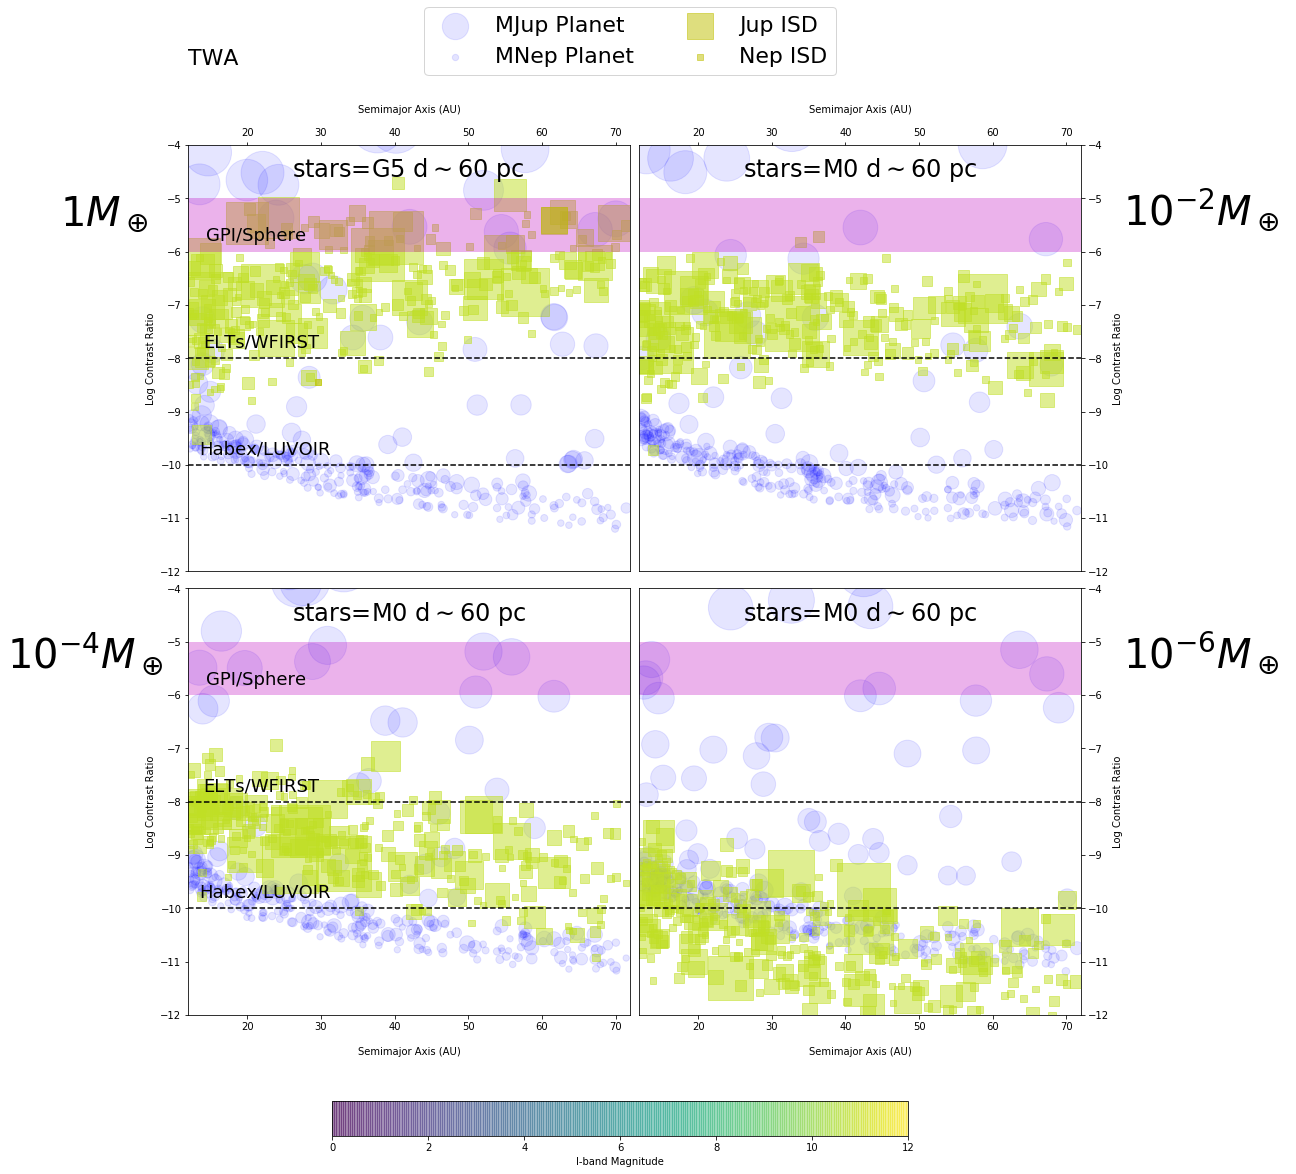

In [14]:
def plot(ax, a, logCRscatSwarm, logCRPlanet, Mplt, Imag, dopt):
    Mcut = 2*Mplt/MEARTH
    ax.scatter(a, logCRPlanet, c='b', vmax=12, vmin=0, s=Mcut, alpha=0.1, marker='o')
    sc = ax.scatter(a, logCRscatSwarm, c=Imag, vmax=12, vmin=0, s=Mcut, alpha=0.5, marker='s')
    ax.axhline(-8, color='k', linestyle='--')
    ax.axhline(-10, color='k', linestyle='--')
    
    ax.set_xlim([IWA*dopt/PC, OWA*dopt/PC])
    ax.set_ylim([-12, -4])
    ax.set_ylabel('Log Contrast Ratio')
    ax.set_xlabel('Semimajor Axis (AU)', labelpad=15)
    mn, mx = ax.get_xlim()
    ax.fill_between(np.linspace(mn, mx, 10), -6, -5, facecolor='m', alpha=0.3)
    return sc

#plt.style.use('paper')
fig, axs = plt.subplots(2, 2, sharey=False, sharex=False, figsize=(16,16))
cm = plt.cm.get_cmap('RdYlBu')
plt.subplots_adjust(wspace=0.02, hspace=0.04)

sc = plot(axs[0,0], a1, np.log10(CRscatSwarm1), np.log10(CRPlanet1), Mplt1, Imag1, dopt1)
sc = plot(axs[0,1], a2, np.log10(CRscatSwarm2), np.log10(CRPlanet2), Mplt2, Imag2, dopt2)
sc = plot(axs[1,0], a4, np.log10(CRscatSwarm4), np.log10(CRPlanet4), Mplt4, Imag4, dopt4)
sc = plot(axs[1,1], a6, np.log10(CRscatSwarm6), np.log10(CRPlanet6), Mplt6, Imag6, dopt6)

#fig, axarr = plt.subplots(figsize=(12,8), ncols=2, gridspec_kw = {'width_ratios':[5, 1]}, sharey=True)

s=0.9
axs[0,0].text(14.4, -5.8, "GPI/Sphere", color='k', fontsize=18)
axs[0,0].text(13.95, -7.8, "ELTs/WFIRST", color='k', fontsize=18)
axs[0,0].text(13.5, -9.8, "Habex/LUVOIR", color='k', fontsize=18)

axs[1,0].text(14.4, -5.8, "GPI/Sphere", color='k', fontsize=18)
axs[1,0].text(13.95, -7.8, "ELTs/WFIRST", color='k', fontsize=18)
axs[1,0].text(13.5, -9.8, "Habex/LUVOIR", color='k', fontsize=18)

axs[0,0].xaxis.set_label_position("top")
axs[0,0].xaxis.tick_top()
axs[0,1].xaxis.set_label_position("top")
axs[0,1].xaxis.tick_top()

axs[0,1].yaxis.set_label_position("right")
axs[0,1].yaxis.tick_right()
axs[1,1].yaxis.set_label_position("right")
axs[1,1].yaxis.tick_right()

ax = axs[0,0]
mn, mx = ax.get_xlim()
avg = (mn+mx)/2
ax.text(0.62*avg, -4.6, r"stars=G5 d$\sim$60 pc", fontsize=24)
ax.text(-0.13*avg, -5.5, r"$1M_\oplus$ ", fontsize=40)
ax = axs[0,1]
mn, mx = ax.get_xlim()
avg = (mn+mx)/2
ax.text(0.62*avg, -4.6, r"stars=M0 d$\sim$60 pc", fontsize=24)
ax.text(1.85*avg, -5.5, r"$10^{-2}M_\oplus$ ", fontsize=40)
ax = axs[1,0]
mn, mx = ax.get_xlim()
avg = (mn+mx)/2
ax.text(0.62*avg, -4.6, r"stars=M0 d$\sim$60 pc", fontsize=24)
ax.text(-0.3*avg, -5.5, r"$10^{-4}M_\oplus$ ", fontsize=40)
ax = axs[1,1]
mn, mx = ax.get_xlim()
avg = (mn+mx)/2
ax.text(0.62*avg, -4.6, r"stars=M0 d$\sim$60 pc", fontsize=24)
ax.text(1.85*avg, -5.5, r"$10^{-6}M_\oplus$ ", fontsize=40)

Mcut1 = 2*Mplt1/MEARTH
Jupmask = np.abs(Mplt1/MEARTH - 318) < 30
Nepmask = np.abs(Mplt1/MEARTH - 20) < 1
sc1 = axs[0,0].scatter(a1[Jupmask][0], np.log10(CRPlanet1)[Jupmask][0], c='b', vmax=12, vmin=0, s=Mcut1[Jupmask][0], alpha=0.1, marker='o', label="MJup Planet")
sc2 = axs[0,0].scatter(a1[Nepmask][0], np.log10(CRPlanet1)[Nepmask][0], c='b', vmax=12, vmin=0, s=Mcut1[Nepmask][0], alpha=0.1, marker='o', label="MNep Planet")
sc3 = axs[0,0].scatter(a1[Jupmask][0], np.log10(CRscatSwarm1)[Jupmask][0], c='y', vmax=12, vmin=0, s=Mcut1[Jupmask][0], alpha=0.5, marker='s', label="Jup ISD")
sc4 = axs[0,0].scatter(a1[Nepmask][0], np.log10(CRscatSwarm1)[Nepmask][0], c='y', vmax=12, vmin=0, s=Mcut1[Nepmask][0], alpha=0.5, marker='s', label="Nep ISD")

axs[0,0].set_title("TWA", loc='left', pad=80, fontsize=22)
axs[0,0].legend(loc='upper center', bbox_to_anchor=(1, 1.35), ncol=2, fontsize=22)

cb_ax = fig.add_axes([0.25, 0.02, 0.5, 0.03])
cbar = fig.colorbar(sc, cax=cb_ax, orientation='horizontal', label='I-band Magnitude')

#plt.colorbar(sc, orientation='horizontal')